# CIFAR-100 Classification with an MDA Head
This notebook trains a small convolutional encoder with a mixture discriminant analysis (MDA) head
on CIFAR-100, then plots train/test accuracy.


### Setup


In [1]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from dnll import MDAHead, EM_DNLLLoss


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device =', device)


device = cuda


### Data


In [3]:
mean = (0.5071, 0.4867, 0.4408)
std = (0.2675, 0.2565, 0.2761)
pin_memory = torch.cuda.is_available()

train_tfm = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_ds = datasets.CIFAR100(root='./data', train=True, transform=train_tfm, download=True)
test_ds  = datasets.CIFAR100(root='./data', train=False, transform=test_tfm, download=True)
train_ld = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=4, pin_memory=pin_memory)
test_ld  = DataLoader(test_ds,  batch_size=1024, shuffle=False, num_workers=4, pin_memory=pin_memory)
len(train_ds), len(test_ds)


100%|██████████| 169M/169M [00:21<00:00, 7.75MB/s] 
/venv/main/lib/python3.12/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


(50000, 10000)

### Model: encoder + MDA head


In [4]:
class Encoder(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
        )
        self.proj = nn.Linear(256, dim)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.proj(x)

class DeepMDA(nn.Module):
    def __init__(self, C, D, K):
        super().__init__()
        self.encoder = Encoder(D)
        self.head = MDAHead(C, D, K)

    def forward(self, x):
        z = self.encoder(x)
        return self.head(z)


### Train & Eval


In [5]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    ok = tot = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        ok += (logits.argmax(1) == y).sum().item()
        tot += y.size(0)
    return ok / tot


model = DeepMDA(C=100, D=99, K=10).to(device)
#opt = torch.optim.Adam([
#    {"params": model.encoder.parameters(), "lr": 1e-3},
#    {"params": model.head.parameters(), "lr": 1e-4},
#])
opt = torch.optim.Adam(model.parameters())
loss_fn = EM_DNLLLoss()

train_acc = []
test_acc = []

for epoch in range(1, 101):
    model.train()
    loss_sum = acc_sum = n_sum = 0
    for x, y in train_ld:
        x, y = x.to(device), y.to(device)
        z = model.encoder(x)
        loss = loss_fn(model.head, z, y)
        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()
        with torch.no_grad():
            logits = model.head(z)
            pred = logits.argmax(1)
            acc_sum += (pred == y).sum().item()
            n_sum += y.size(0)
            loss_sum += loss.item() * y.size(0)
    tr_acc = acc_sum / n_sum
    te_acc = evaluate(model, test_ld)
    train_acc.append(tr_acc)
    test_acc.append(te_acc)
    print(f'[MDA {epoch:02d}] train loss={loss_sum/n_sum:.4f} acc={tr_acc:.4f} | test acc={te_acc:.4f}')


[MDA 01] train loss=10.2484 acc=0.0550 | test acc=0.1087
[MDA 02] train loss=5.4247 acc=0.2153 | test acc=0.2376
[MDA 03] train loss=4.3080 acc=0.3305 | test acc=0.3064
[MDA 04] train loss=3.7934 acc=0.4042 | test acc=0.3888
[MDA 05] train loss=3.4750 acc=0.4571 | test acc=0.4382
[MDA 06] train loss=3.2527 acc=0.5011 | test acc=0.4576
[MDA 07] train loss=3.0876 acc=0.5364 | test acc=0.4826
[MDA 08] train loss=2.9749 acc=0.5574 | test acc=0.5027
[MDA 09] train loss=2.8718 acc=0.5799 | test acc=0.4981
[MDA 10] train loss=2.7894 acc=0.5988 | test acc=0.5141
[MDA 11] train loss=2.7110 acc=0.6184 | test acc=0.5491
[MDA 12] train loss=2.6418 acc=0.6343 | test acc=0.5161
[MDA 13] train loss=2.5835 acc=0.6482 | test acc=0.5532
[MDA 14] train loss=2.5347 acc=0.6591 | test acc=0.5826
[MDA 15] train loss=2.4837 acc=0.6726 | test acc=0.5632
[MDA 16] train loss=2.4404 acc=0.6864 | test acc=0.6032
[MDA 17] train loss=2.3991 acc=0.6958 | test acc=0.5872
[MDA 18] train loss=2.3687 acc=0.7041 | test ac

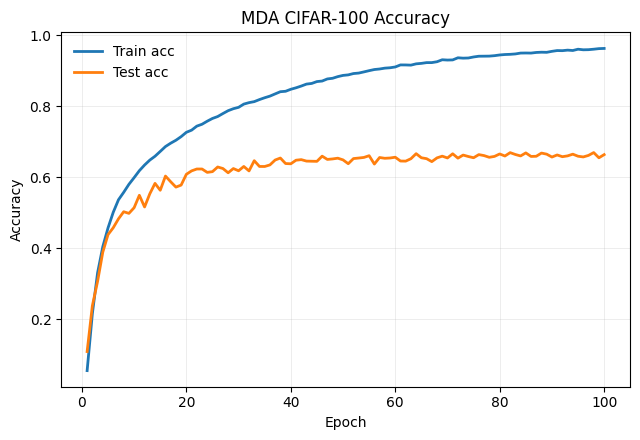

In [6]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_acc) + 1)
plt.figure(figsize=(6.5, 4.5))
plt.plot(epochs, train_acc, label='Train acc', linewidth=2)
plt.plot(epochs, test_acc, label='Test acc', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('MDA CIFAR-100 Accuracy')
plt.legend(frameon=False)
plt.grid(True, linewidth=0.4, alpha=0.4)
plt.tight_layout()
plt.show()
